## Fragment long viral RNA 

In [1]:
from rouskinhf import convert
import pandas as pd
import numpy as np

from src import compare_frags, fragment_RNA

### SARS

In [2]:
# ## Import data from Sun

# # Import ct file
# data = convert(
#     'ct',
#     'data/SARS2/Sun/',
#     name='SARS2',
#     path_out='',
#     filter=False
# )
# df = pd.DataFrame(data).T
# sequence_Sun = df['sequence']['SARS2'].upper().replace('T','U')
# paired_bases_Sun = np.array(df['structure']['SARS2'])


# # Import shape file
# UKN = -1000
# data_shape = pd.read_excel('data/SARS2/Sun/GSE153984_SARS2-icSHAPE.xlsx', header=None)
# data_shape.fillna(UKN, inplace=True)

# full_shape_Sun = data_shape[2].values
# assert ''.join(data_shape[1].tolist()).upper().replace('T','U') == sequence_Sun, 'Sequence mismatch'

In [3]:
## Import data from Lan

# Import ct file
data = convert(
    'ct',
    'data/SARS2/Lan/',
    name='SARS',
    path_out='',
    filter=False
)
df = pd.DataFrame(data).T
sequence_Lan = df['sequence']['SARS']
paired_bases_Lan = np.array(df['structure']['SARS'])

# Import dms file
UKN = -1000
data_dms = pd.read_excel('data/SARS2/Lan/SARS_DMS.xlsx')
data_dms.fillna(UKN, inplace=True)

full_dms_Lan = data_dms['Vero (filtered)'].values
max_dms = np.median(full_dms_Lan[full_dms_Lan!=UKN][full_dms_Lan[full_dms_Lan!=UKN]>np.percentile(full_dms_Lan[full_dms_Lan!=UKN], 95)])
full_dms_Lan[full_dms_Lan!=UKN] =  full_dms_Lan[full_dms_Lan!=UKN] / max_dms
full_dms_Lan[full_dms_Lan>1] = 1

assert ''.join(data_dms['Nucleotide'].tolist()) == sequence_Lan, 'Sequence mismatch'

Parsing ct files:   0%|          | 0/1 [00:00<?, ?it/s]

Parsing ct files: 100%|██████████| 1/1 [00:00<00:00, 37.74it/s]


Drop 0 datapoints with None values (null sequence or reference)


In [4]:
# data_SARS = compare_frags([sequence_Lan, sequence_Sun], [full_dms_Lan, full_shape_Sun], [paired_bases_Lan, paired_bases_Sun],
#                           min_f1=0.9, name='SARS2', min_length=100, min_unpaired_length=10, min_auroc=0.8)

# We keep fragment 0 which is DMS data

In [5]:
data_SARS = fragment_RNA(sequence_Lan, paired_bases_Lan, full_dms_Lan, 
                               name="SARS", data_type='dms', min_length=100, min_unpaired_length=10, min_auroc=0.8)

data_SARS = data_SARS[data_SARS.sequence.str.len() < 1000]

### HIV

In [6]:
all_struct_HIV = pd.read_excel('data/HIV/nar-01265-r-2015-File010.xlsx', header=1)

def convert_to_CT(df, column, name, path):
    df_CT = df[['Position', 'Nucleotide ', column]].copy()

    df_CT['Position+1'] = df_CT['Position'] + 1
    df_CT['Position-1'] = df_CT['Position'] - 1
    df_CT[['Position', 'Nucleotide ', 'Position-1', 'Position+1', column, 'Position']].to_csv(path, sep='\t', index=False, header=[name, str(len(df))]+['']*4)


convert_to_CT(all_struct_HIV, column='Watts09', name='HIV', path='data/HIV/Watts/HIV.ct')
# convert_to_CT(all_struct_HIV, column='PPfold, SHAPE', name='HIV', path='data/HIV/Sukosd/HIV.ct')

# Import shape file
UKN = -1000
data_shape = pd.read_csv('data/HIV/Sukosd/41586_2009_BFnature08237_MOESM312_ESM.txt', header=None, sep='\t')
data_shape.fillna(UKN, inplace=True)
full_shape_HIV = data_shape[2].values

In [7]:
# Import ct file from Watts
data = convert(
    'ct',
    'data/HIV/Watts/',
    name='HIV',
    path_out='',
    filter=False
)
df = pd.DataFrame(data).T
sequence_Watts = df['sequence']['HIV'].upper().replace('T','U')
paired_bases_Watts = np.array(df['structure']['HIV'])

assert ''.join(data_shape[1].tolist()).upper().replace('T','U') == sequence_Watts, 'Sequence mismatch'

Parsing ct files: 100%|██████████| 1/1 [00:00<00:00, 130.17it/s]

Drop 0 datapoints with None values (null sequence or reference)


In [8]:
# # Import ct file from Sukosd
# data = convert(
#     'ct',
#     'data/HIV/Sukosd/',
#     name='HIV',
#     path_out='',
#     filter=False
# )
# df = pd.DataFrame(data).T
# sequence_Sukosd = df['sequence']['HIV'].upper().replace('T','U')
# paired_bases_Sukosd = np.array(df['structure']['HIV'])

# assert ''.join(data_shape[1].tolist()).upper().replace('T','U') == sequence_Sukosd, 'Sequence mismatch'

In [9]:
# gold_data_HIV = compare_frags([sequence_Sukosd, sequence_Watts], [full_shape_HIV, full_shape_HIV], [paired_bases_Sukosd, paired_bases_Watts],
#               name='HIV', min_length=40, min_unpaired_length=3, min_auroc=0.8, min_f1=0.8)

# gold_data_HIV.rename(columns={'dms':'shape'}, inplace=True)

In [10]:
data_HIV = fragment_RNA(sequence_Watts, paired_bases_Watts, full_shape_HIV, 
                               name="HIV", data_type='shape', min_length=100, min_unpaired_length=10, min_auroc=0.8)

data_HIV = data_HIV[data_HIV.sequence.str.len() < 1000]

### Alphavirus

In [11]:
file = pd.ExcelFile('data/Alphavirus/nar-02140-r-2017-File007.xlsx')
full_shape_alphavirus = pd.read_excel(file, 'datamatrix')['SINV_mean'].values
sequence_alphavirus = pd.read_excel(file, 'study_assays')['Characteristics[Nucleotide Sequence]'][0].upper().replace('T','U')


In [12]:
# Import ct file from Watts
data = convert(
    'ct',
    'data/Alphavirus/',
    name='Alphavirus',
    path_out='',
    filter=False
)
df = pd.DataFrame(data).T
paired_bases_Alphavirus = np.array(df['structure']['Alphavirus'])

assert df['sequence']['Alphavirus'].upper().replace('T','U') == sequence_alphavirus, 'Sequence mismatch'

Parsing ct files: 100%|██████████| 1/1 [00:00<00:00, 87.50it/s]

Drop 0 datapoints with None values (null sequence or reference)


In [13]:
data_Alphavirus = fragment_RNA(sequence_alphavirus, paired_bases_Alphavirus, full_shape_alphavirus, 
                               name="Alphavirus", data_type='shape', min_length=100, min_unpaired_length=5, min_auroc=0.75)

data_Alphavirus = data_Alphavirus[data_Alphavirus.sequence.str.len() < 1000]
data_Alphavirus

,sequence,shape
Alphavirus_1,ACCAUGCAAAAUUACCUUCUGCCAAUCAUUGCACAAGGGUUCAGCA...,"[0.988914, 0.305118, 0.816804, 0.729592, 0.435..."
Alphavirus_2,UACAGAAGAGGAGCAGUACAAGGUUACAAAGGCAGAGCUCGCAGAA...,"[1.955574, 0.929837, 1.850531, 0.724326, 2.009..."
Alphavirus_3,CAUUACGAUGGAAAAAUGAAAACCACAAACCCGUGCAAGAAGAACA...,"[0.247756, 0.70547, 0.645837, 1.133421, 0.7441..."
Alphavirus_4,AUUCUUGAGCCAGUUCAAACACCACUCCGUACUUGUGGUCUCAGAG...,"[0.847907, 1.002079, 0.408423, 0.782771, 0.848..."
Alphavirus_5,UCCGGAAACACCCAGAGGCAGAAGCCCUGAAAUUGCUGCAAAACGC...,"[0.131674, 0.210302, 0.158655, 0.251467, 0.537..."
Alphavirus_6,UAUGCCAUGACGCCAGAAAGGGUCCACAGACUCAGAAGCAACAACG...,"[1.900373, 0.821938, 0.794448, 0.375399, 0.304..."
Alphavirus_7,GACUAACCGGGGUAGGUGGGUACAUAUUUUCGACGGACACAGGCCC...,"[1.361058, 0.683011, 0.746563, 2.065112, 1.285..."
Alphavirus_8,UCCGCAGUGCGGUUCCAUCAGCGAUGCAGAACACGUUGCAAAACGU...,"[0.451851, 1.090299, 0.503538, 0.138209, 0.161..."
Alphavirus_9,UUUGGUCCCAUUGCAAGAAGUGCCUAUGGAUAGGUUCGUCAUGGAC...,"[0.777774, 0.520196, 0.608084, 0.043007, 0.102..."
Alphavirus_10,ACAGAAGACGCGCUCUGCUAGAUGAAACAAAGGCGUGGUUUAGAGU...,"[0.770969, 1.15267, 1.140923, 1.635912, 1.0787..."


In [14]:
# fragments_coordinates = [
#     [43, 345],
#     [694, 1019],
#     [1293, 1381],
#     [1507, 1691],
#     [2409, 2560],
#     [3823, 3959],
#     [4055, 4094],
#     [4172, 4207],
#     [5092, 5139],
#     [5211, 5361],
#     [5443, 5629],
#     [6326, 6386],
#     [7599, 7831],
#     [9296, 9330],
#     [10027, 10168],
#     [10825, 10910],
#     [11629, 11661]
# ]

# gold_data_alpha = pd.DataFrame(columns=['reference', 'sequence', 'shape'])

# for i, (start, end) in enumerate(fragments_coordinates):
#     gold_data_alpha.loc[i] = [f'Alphavirus_{i}', sequence_alphavirus[start:end], full_shape_alphavirus[start:end].tolist()]
# gold_data_alpha.set_index('reference', inplace=True)

In [15]:
with open('data/Alphavirus/Alphavirus.seq', 'w') as f:
    f.write(';\n')
    f.write('Alphavirus2\n')
    f.write(sequence_alphavirus.upper()+ '\n')
    f.write('1\n')

with open('data/Alphavirus/Alphavirus.shape', 'w') as f:
    for i, s in enumerate(full_shape_alphavirus):
        f.write(f'{i+1}\t{s}\n')

### Chikungunya

In [16]:
# file = pd.ExcelFile('data/Alphavirus/nar-02140-r-2017-File007.xlsx')
# full_shape_alphavirus = pd.read_excel(file, 'datamatrix')['SINV_mean'].values
# sequence_alphavirus = pd.read_excel(file, 'study_assays')['Characteristics[Nucleotide Sequence]'][0].upper().replace('T','U')


### Hepatitis

In [17]:
version = 'Con1b'
file = pd.ExcelFile('data/Hepatitis/pnas.1416266112.sd01.xlsx')
full_shape_hepatitis = pd.read_excel(file, version)['Reactivity'].values
sequence_hepatitis = ''.join(pd.read_excel(file, version)['Base'].tolist()).upper().replace('T','U')

/Users/alberic/.pyenv/versions/3.10.9/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/alberic/.pyenv/versions/3.10.9/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [18]:
# Import ct file from Con1b
data = convert(
    'ct',
    f'data/Hepatitis/{version}',
    name='Hepatitis',
    path_out='',
    filter=False
)
df = pd.DataFrame(data).T
paired_bases_hepatitis = np.array(df['structure'][list(data.keys())[0]])

assert df['sequence'][list(data.keys())[0]].upper().replace('T','U') == sequence_hepatitis, 'Sequence mismatch'

Parsing ct files: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]

Drop 0 datapoints with None values (null sequence or reference)


In [19]:
data_Hepatitis = fragment_RNA(sequence_hepatitis, paired_bases_hepatitis, full_shape_hepatitis, 
                               name="Hepatitis", data_type='shape', min_length=100, min_unpaired_length=10, min_auroc=0.7)

data_Hepatitis = data_Hepatitis[data_Hepatitis.sequence.str.len() < 1000]
data_Hepatitis

,sequence,shape
Hepatitis_1,GCUGUUCACCUUCUCGCCUCGCCGGCACGAGACAGUACAGGACUGC...,"[0.89175, 0.072936, 1.1954, -0.00401, 0.59478,..."
Hepatitis_2,AGGCUUUGGCACUACCCCUGCACUGUCAACUUUACCAUCUUCAAGG...,"[0.89245, 0.59936, 0.4735, -0.21851, 0.53626, ..."
Hepatitis_3,GAGCGUUGUAACCUGGAGGACAGGGACAGAUCAGAGCUUAGCCCGC...,"[0.5931, 0.318, 0.5738, 0.4055, 0.50284, 0.727..."
Hepatitis_4,GCGCGCGUCUGUGCCUGCUUGUGGAUGAUGCUGCUGAUAGCUCAAG...,"[-0.014156, 0.1968, 0.08744, 0.069652, 0.29264..."
Hepatitis_5,ACCACCACGAGCAUACGCCAUGGACCGGGAGAUGGCAGCAUCGUGC...,"[0.35619, 0.66034, 0.3838, 0.56116, 0.80541, -..."
Hepatitis_6,GUGCUCCAGGCUGGUAUAACCAAAGUGCCGUACUUCGUGCGCGCAC...,"[-0.10669, 0.15505, 0.69098, 0.092452, 0.53449..."
Hepatitis_7,CAUCAUCUUGGGCCUGCCCGUCUCCGCCCGCAGGGGGAGGGAGAUA...,"[0.88659, 2.0697, 1.0676, 0.77684, 0.36026, 0...."
Hepatitis_8,CCCCUCCGGCCGUACCGCAGACAUUCCAGGUGGCCCAUCUACACGC...,"[0.94404, -0.23254, 0.47834, 0.042551, 0.28067..."
Hepatitis_9,CGACCUUCACCAUUGAGACGACGACCGUGCCACAAGACGCGGUGUC...,"[0.12906, 0.58521, 0.5747, 0.8317, 0.20441, 1...."
Hepatitis_10,CAGGCAGGAGACAACUUCCCCUACCUGGUAGCAUACCAGGCUACGG...,"[0.3571, 0.58633, 0.88794, 0.44589, 0.29805, 1..."


### Combine and export

In [20]:
from rouskinhf import dump_json
dump_json(pd.concat([data_SARS, data_HIV, data_Hepatitis, data_Alphavirus]).to_dict(orient='index'),
          'data/viral_fragments.json')

## Convert to rouskinHF

In [21]:
import envbash
envbash.load.load_envbash('../.env')
from rouskinhf import convert, upload_dataset, get_dataset

## RouskinHF filtering

In [22]:
from rouskinhf import convert

data = convert(
    'json',
    'data/viral_fragments.json',
    name='viral_fragments',
    path_out='data',
    filter=True,
    predict_structure=True,
    min_AUROC=0.7
)

Parsing json file: 100%|██████████| 63/63 [03:52<00:00,  3.68s/it]

Over a total of 63 datapoints, there are:
### OUTPUT
- ALL: 58 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape
- 5 datapoints removed because of low AUROC (<0.7)


<AxesSubplot: >

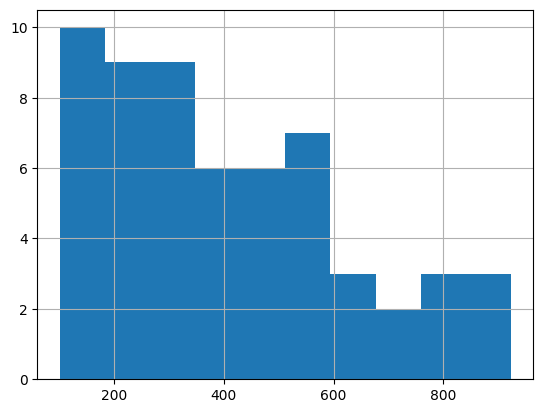

In [26]:
pd.DataFrame.from_dict(data).T.sequence.apply(len).hist()

In [27]:
pd.DataFrame.from_dict(data).T

,sequence,structure,dms,shape
SARS_0,AUUAAAGGUUUAUACCUUCCCAGGUAACAAACCAACCAACUUUCGA...,"[[62, 72], [4, 76], [61, 73], [101, 109], [3, ...","[0.0, -1000.0, -1000.0, 0.0119, 0.1542, 0.2179...",NaN
SARS_1,CUAAUUACUGUCGUUGACAGGACACGAGUAACUCGUCUAUCUUCUG...,"[[15, 149], [16, 148], [212, 251], [213, 250],...","[1.0, -1000.0, 0.5671, 0.4416, -1000.0, -1000....",NaN
SARS_2,UUAAAGAUGGCACUUGUGGCUUAGUAGAAGUUGAAAAAGGCGUUUU...,"[[12, 68], [224, 241], [188, 196], [8, 73], [1...","[-1000.0, -1000.0, 0.2593, 0.5651, 0.6353, -10...",NaN
SARS_3,AAACUGGAACACUAAACAUAGCAGUGGUGUUACCCGUGAACUCAUG...,"[[36, 56], [129, 156], [20, 75], [22, 72], [21...","[0.1761, 0.4973, 0.6295, 0.6609, -1000.0, -100...",NaN
SARS_4,CACUAAGAGGGGUGUAUACUGCUGCCGUGAACAUGAGCAUGAAAUU...,"[[62, 75], [11, 91], [63, 74], [18, 87], [30, ...","[0.5168, 0.5928, 0.8437, -1000.0, 0.5368, 0.60...",NaN
SARS_5,UUAAAUUGGCAAAGAAAUUUGACACCUUCAAUGGGGAAUGUCCAAA...,"[[195, 217], [203, 209], [13, 335], [20, 328],...","[-1000.0, -1000.0, 0.066, 0.3447, 0.3712, -100...",NaN
SARS_6,AUUCAGAAGUAGGACCUGAGCAUAGUCUUGCCGAAUACCAUAAUGA...,"[[818, 827], [819, 826], [330, 335], [472, 492...","[0.5336, -1000.0, -1000.0, 0.3758, 0.4228, -10...",NaN
SARS_7,AUUAAGGAGAGUGUUCAGACAUUCUUUAAGCUUGUAAAUAAAUUUU...,"[[183, 252], [42, 100], [184, 251], [63, 80], ...","[0.4403, -1000.0, -1000.0, 0.4172, 0.7117, -10...",NaN
SARS_8,CUUGAAAACUGGUGAUUUACAACCAUUAGAACAACCUACUAGUGAA...,"[[317, 341], [232, 263], [188, 205], [315, 343...","[0.6516, -1000.0, -1000.0, -1000.0, 0.5993, 0....",NaN
SARS_9,UUACACCACUGGGCAUUGAUUUAGAUGAGUGGAGUAUGGCUACAUA...,"[[97, 127], [282, 319], [27, 50], [167, 173], ...","[-1000.0, -1000.0, 0.6526, 0.6604, 0.3378, 0.2...",NaN


## To HuggingFace

In [28]:
from rouskinhf import upload_dataset

upload_dataset(
    'data/viral_fragments/data.json',
    commit_message='added Alphavirus',
    exist_ok=True
)